## Import all required tools

In [1]:
import ixmp
import message_ix
import numpy as np
import pandas as pd
import yaml

import matplotlib.pyplot as plt

from collections.abc import Mapping
from itertools import repeat
from message_ix.models import MESSAGE_ITEMS
from message_ix.utils import make_df
from message_ix.tools.add_dac import add_tech
from message_ix.tools.add_dac import get_report
from message_ix.tools.add_dac import get_values

%matplotlib inline


mp = ixmp.Platform()


<IPython.core.display.Javascript object>

C:\Users\pratama\Documents\GitHub\MESSAGEix\message_ix\message_ix\reporting\__init__.py:98: FutureWarning: Importing from genno.computations will be deprecated in a future version; use genno.operator instead.
  ("tom:nl-t-yv-ya", (genno.computations.add, "fom:nl-t-yv-ya", "vom:nl-t-yv-ya")),


In [2]:
def plotvars(scenario):
    # CO2 Emission
    emiss = scenario.var("EMISS")
    emiss = emiss.loc[(emiss['type_tec'] == 'all') & 
                      (emiss['node'] == 'World') & 
                      (emiss['emission'] == 'TCE')]
    emiss_plot = emiss[['year','lvl']].set_index(['year']).div(1000)

    # CO2 Removal
    removal = scenario.var("EMISS")
    removal = removal.loc[(removal['type_tec'] == 'all') & 
                          (removal['node'] == 'World') & 
                          (removal['emission'] == 'CO2_storage')]
    removal_plot = removal[['year','lvl']].set_index(['year']).div(1000)

    # CO2 Prices
    CO2Price = (scenario.var("PRICE_EMISSION")
                .loc[scenario.var("PRICE_EMISSION")['type_emission'] == 'TCE'][['year','lvl']]
                .set_index(['year'])).div(1000)
    
    
    plt.figure(figsize=(4,4))
    # Plottings
    plt.plot(emiss_plot, label='CO2 Emission')
    plt.plot(removal_plot, label='CO2 Removal')
    plt.plot(CO2Price, label='CO2 Price')
    
    plt.ylim(-10,40)
    plt.ylabel("thousands of var unit")
    
    plt.legend()
    plt.show()

## Run SSP_dev DAC baseline scenario
**Clone and create SSP_dev DAC baseline scenario**

In [3]:
SSPs = ["SSP1","SSP2","SSP3","SSP4","SSP5"]
SSPs = ["SSP1","SSP2","SSP5"]
mpens = ["mpen1","mpen5"]
scenariotec = ['dac_lt','dac_ht']

scenarios = {f"SSP_dev_{ssp}_v0.1_dac": 
             {f"1000f_v0.13_dac-co2split_{mpen}": [] for mpen in mpens} 
             for ssp in SSPs
            }


In [4]:
for k,v in scenarios.items():
    for k1,v1 in v.items():
        scen = message_ix.Scenario(mp, model=k, scenario=k1)
        acts = get_values(scen,"ACT").droplevel(["mode","time"])
        removal = (acts.loc[:, scenariotec, :, :]["lvl"].unstack().fillna(0)
                   .groupby(["node_loc"]).sum())
        removal.loc["World"] = removal.sum(axis=0)
        scenarios[k][k1] = removal
        


In [5]:
colors = {"SSP1":"tab:red","SSP2":"tab:orange","SSP3":"tab:green","SSP4":"tab:blue","SSP5":"tab:purple",}
lines = {"mpen1":"-","mpen2":"--","mpen3":"-.","mpen4":":","mpen5":(0, (3, 1, 1, 1, 1, 1))}

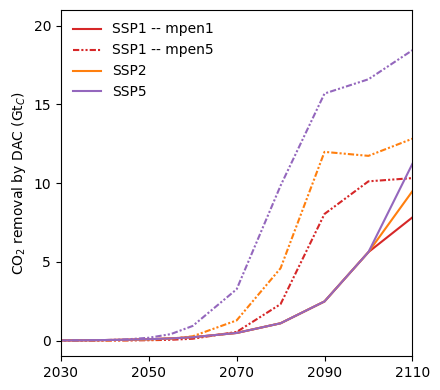

In [6]:
plt.figure(figsize=(4.5,4))
for ssp in SSPs:
    for mpen in mpens:
        model = f"SSP_dev_{ssp}_v0.1_dac"
        scenario = f"1000f_v0.13_dac-co2split_{mpen}"
        
        if ssp == "SSP1":
            kwargs = {"label": f"{ssp} -- {mpen}"}
        elif ssp != "SSP1" and mpen == "mpen1":
            kwargs = {"label": f"{ssp}"}
        else:
            kwargs = {}
        
        plt.plot(scenarios[model][scenario].div(1000).loc["World"], ls=lines[mpen], c=colors[ssp], **kwargs)

plt.ylim(-1,21)
plt.xlim(2030,2110)
plt.xticks(range(2030,2120,20))
plt.yticks(range(0,25,5))
plt.ylabel("CO$_2$ removal by DAC (Gt$_C$)")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("dac_ssp.jpeg",dpi=300)
plt.show()

# CO2 storage utilization

# CO2 Storage SSPs

In [7]:
storage_list = []
for ssp in SSPs:
    for mpen in mpens:
        model = f"SSP_dev_{ssp}_v0.1_dac"
        scenario = f"1000f_v0.13_dac-co2split_{mpen}"
        
        scen = message_ix.Scenario(mp, model=model, scenario=scenario)
        
        removal = (scen.var("ACT", {"technology":"co2_stor"})
           .drop(["technology","year_vtg","time"], axis=1)
           .set_index(["node_loc","year_act","mode"])["lvl"]
          ).swaplevel(1,2).unstack().swaplevel(0,1).groupby(level=[0]).sum()
        removal.index = ["fossil-co2","bio-co2","dac-co2"]
        len_periods = [5,5,5,5,5,5,5,5,10,10,10,10,10]
        removal = removal.mul(len_periods, axis=1)

        cumulative_storage = removal.cumsum(axis=1).div(1000) # make it GtC
        
        total_stor = cumulative_storage[[2100]]
        total_stor = total_stor.rename(columns={2100:f"{ssp}\n{mpen}"})
        
        storage_list += [total_stor]
        

In [8]:
mpen_names = ["MP1","MP2","MP3","MP4","MP5"]
mpen_names = ["MP1","MP5"]

ssp1_total_stor = pd.concat(storage_list[0:2], axis=1).transpose()
ssp1_total_stor.index = mpen_names
ssp1_total_stor = ssp1_total_stor.transpose()
ssp2_total_stor = pd.concat(storage_list[2:4], axis=1).transpose()
ssp2_total_stor.index = mpen_names
ssp2_total_stor = ssp2_total_stor.transpose()
ssp5_total_stor = pd.concat(storage_list[4:6], axis=1).transpose()
ssp5_total_stor.index = mpen_names
ssp5_total_stor = ssp5_total_stor.transpose()

ssp_total_stor = [ssp1_total_stor,ssp2_total_stor,ssp5_total_stor]

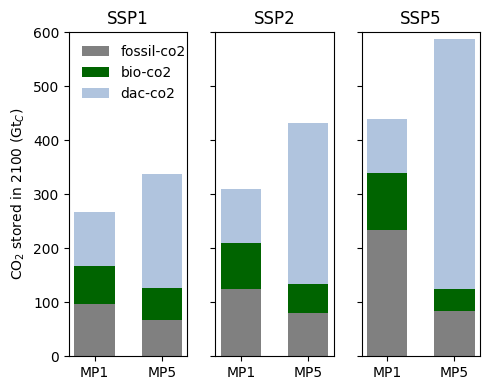

In [9]:
colors = {"fossil-co2":"gray","bio-co2":"darkgreen","dac-co2":"lightsteelblue"}

width = 0.6

fig, axs = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(5,4))
bottom1 = np.zeros(2)
bottom2 = np.zeros(2)
bottom5 = np.zeros(2)

for source in colors.keys():
    ssp1 = axs[0].bar(ssp1_total_stor.columns, ssp1_total_stor.loc[source], width, label=source, bottom=bottom1,
               color = colors[source]
              )
    ssp2 = axs[1].bar(ssp2_total_stor.columns, ssp2_total_stor.loc[source], width, label=source, bottom=bottom2,
               color = colors[source]
              )
    ssp5 = axs[2].bar(ssp5_total_stor.columns, ssp5_total_stor.loc[source], width, label=source, bottom=bottom5,
               color = colors[source]
              )
    
    bottom1 += ssp1_total_stor.loc[source]
    bottom2 += ssp2_total_stor.loc[source]
    bottom5 += ssp5_total_stor.loc[source]

#ax.set_xticks(range(2025,2045,5))
axs[0].set_title("SSP1")
axs[1].set_title("SSP2")
axs[2].set_title("SSP5")
axs[0].set_ylim(0,600)
axs[0].set_ylabel("CO$_2$ stored in 2100 (Gt$_C$)")
axs[0].legend(loc="upper left", frameon=False)
plt.tight_layout()
plt.savefig("cum_co2stored.jpeg",dpi=300)
plt.show()

## Close connection

In [10]:
mp.close_db()